# 🎵 Music Genre Classification with CNN

## Description
Build a **Convolutional Neural Network (CNN)** model to classify music genres from audio files.  
Key tasks include:  
- **Feature Extraction**: Convert audio files into meaningful features for the model (e.g., MFCCs, spectrograms).  
- **Data Augmentation**: Apply transformations to increase dataset diversity and improve model generalization.  
- **Classification Accuracy**: Optimize the CNN architecture and training pipeline for better performance.

## Dataset
**GTZAN Music Genre Dataset**  
- 10 music genres  
- 100 audio tracks per genre (30 seconds each)  
- Widely used benchmark for music genre classification tasks


# Step 1: Dataset Selection

In [1]:
import os
import zipfile

# Set Kaggle config directory to folder containing kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = r"C:\Users\user\Downloads"

# Download dataset using kaggle CLI
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

# Unzip using Python
with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('GTZAN')


Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


# Step 2: Data Cleaning
- Address mislabeled images by manual inspection or automated methods if possible. 
- Standardize image dimensions (resizing) and color channels (e.g., converting to grayscale or ensuring consistent RGB). 
- Handle corrupted or unreadable image files. 
- Normalize pixel values (e.g., scaling to [0, 1] or [-1, 1]). 
- Document all cleaning steps and their rationale. 

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "GTZAN/Data/genres_original" # Path to raw audio files
SAMPLE_RATE = 22050                 # Standard audio sampling rate
DURATION = 30                      # Duration to fix audio length (seconds)
SAMPLES = SAMPLE_RATE * DURATION   # Number of samples in fixed length

# Step 1: Check for corrupted/unreadable audio files by attempting to load a short segment
corrupted_files = []
for genre in os.listdir(DATA_DIR):
    genre_path = os.path.join(DATA_DIR, genre)
    if not os.path.isdir(genre_path):
        continue
    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=5)  # Load 5 sec to test file integrity
        except Exception as e:
            corrupted_files.append(file_path)  # Log corrupted files
            print(f"Corrupted or unreadable file: {file_path}, error: {e}")

print(f"Total corrupted files found: {len(corrupted_files)}")  # Report corrupted file count


C:\Users\user\AppData\Local\Temp\ipykernel_1576\40344908.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=5)  # Load 5 sec to test file integrity
C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Corrupted or unreadable file: GTZAN/Data/genres_original\jazz\jazz.00054.wav, error: 
Total corrupted files found: 1


In [3]:
import os

corrupted_files = ["GTZAN/Data/genres_original/jazz/jazz.00054.wav"]

for f in corrupted_files:
    if os.path.exists(f):
        print(f"Deleting corrupted file: {f}")
        os.remove(f)
    else:
        print(f"File not found for deletion: {f}")


Deleting corrupted file: GTZAN/Data/genres_original/jazz/jazz.00054.wav


In [4]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set path to raw audio files
AUDIO_DIR = r"GTZAN/Data/genres_original"
# Set path to save generated spectrogram images
SPEC_DIR = r"GTZAN/spectrograms"
# Create spectrogram output directory if it doesn't exist
os.makedirs(SPEC_DIR, exist_ok=True)

# Function to convert audio file to mel spectrogram image and save it
def create_spectrogram(audio_path, output_path):
    try:
        # Load first 30 seconds of audio file
        y, sr = librosa.load(audio_path, duration=30)
        # Compute mel spectrogram with 128 mel bands
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        # Convert power spectrogram to decibel scale
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Create matplotlib figure sized to 224x224 pixels (2.24 inches at 100 dpi)
        plt.figure(figsize=(2.24, 2.24), dpi=100)
        # Display mel spectrogram without axes and using 'magma' colormap
        librosa.display.specshow(mel_db, sr=sr, x_axis=None, y_axis=None, cmap='magma')
        plt.axis('off')                  # Hide axis ticks and labels
        plt.tight_layout(pad=0)          # Remove padding around figure
        # Save figure to output path without extra whitespace
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()                     # Close the plot to free memory

    except Exception as e:
        # Print error message if audio file processing fails
        print(f"Error processing {audio_path}: {e}")

# Loop over each genre folder in the audio dataset
for genre in os.listdir(AUDIO_DIR):
    genre_path = os.path.join(AUDIO_DIR, genre)
    # Skip non-directory files
    if not os.path.isdir(genre_path):
        continue

    # Create output directory for this genre’s spectrograms
    genre_output_path = os.path.join(SPEC_DIR, genre)
    os.makedirs(genre_output_path, exist_ok=True)

    # Loop over each audio file in the genre folder with a progress bar
    for file in tqdm(os.listdir(genre_path), desc=f"Converting {genre}"):
        # Process only .wav files
        if file.endswith(".wav"):
            audio_file_path = os.path.join(genre_path, file)
            # Set output image path with .png extension
            output_img_path = os.path.join(genre_output_path, file.replace(".wav", ".png"))
            # Convert audio to spectrogram image and save it
            create_spectrogram(audio_file_path, output_img_path)


Converting rock: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


In [5]:
from PIL import Image
import os
import numpy as np

# Step 4: Function to resize images to 224x224 and convert to RGB
def resize_and_standardize(image_path):
    try:
        img = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
        img = img.resize((224, 224))                 # Resize image to 224x224 pixels
        return img
    except Exception as e:
        # Print error message for corrupted/unreadable images
        print(f"Corrupted image: {image_path} | Error: {e}")
        return None  # Return None if image is corrupted or unreadable


In [6]:
cleaned_data = []
for genre in os.listdir(SPEC_DIR):
    genre_folder = os.path.join(SPEC_DIR, genre)
    # Skip if genre_folder is not a directory (avoid files or system folders)
    if not os.path.isdir(genre_folder):
        continue

    for image_file in os.listdir(genre_folder):
        img_path = os.path.join(genre_folder, image_file)
        # Process only .png image files, skip directories and other file types
        if not image_file.lower().endswith(".png"):
            continue

        img = resize_and_standardize(img_path)  # Resize and convert to RGB
        if img is not None:                     # Only proceed if image is valid
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0,1]
            cleaned_data.append((img_array, genre))  # Append image and label


In [7]:
# Step 5: Print a summary of the cleaning process

# Print total number of cleaned (valid) images processed
print(f"Total cleaned images: {len(cleaned_data)}")

# Print total number of genre folders (classes) detected
print(f"Total genres: {len(os.listdir(SPEC_DIR))}")

Total cleaned images: 999
Total genres: 11


In [9]:
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Step 3: Data Exploration (EDA)
### Utilize statistical and visual methods to understand the data. 
- Display sample images from each class.  

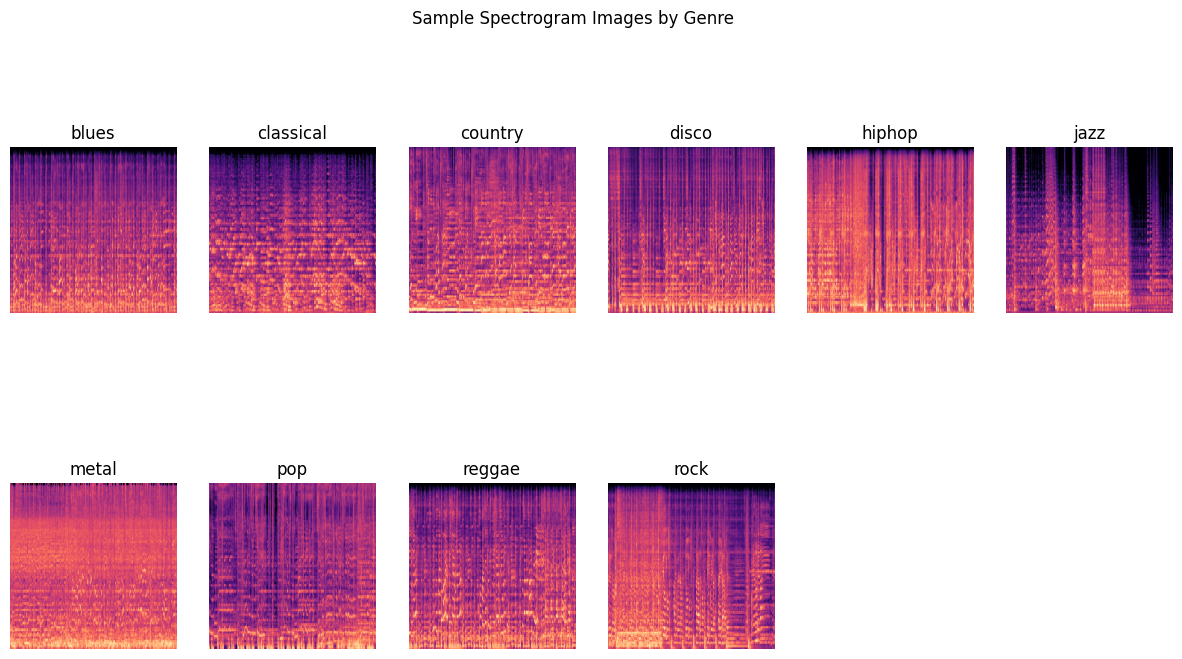

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os

# Step 3.1: Display sample images from each genre (class)
samples_per_genre = {}

for genre in os.listdir(SPEC_DIR):
    genre_folder = os.path.join(SPEC_DIR, genre)
    # Skip if not a directory
    if not os.path.isdir(genre_folder):
        continue

    for image_file in os.listdir(genre_folder):
        # Process only .png images
        if not image_file.lower().endswith(".png"):
            continue

        img_path = os.path.join(genre_folder, image_file)
        try:
            img = Image.open(img_path).convert("RGB")  # Open and convert to RGB
        except Exception as e:
            print(f"Could not open {img_path}: {e}")
            continue

        if genre not in samples_per_genre:
            samples_per_genre[genre] = np.array(img)
            break  # Only take one sample per genre

# Plot one sample image per genre
plt.figure(figsize=(15, 8))
for i, (genre, img) in enumerate(samples_per_genre.items()):
    plt.subplot(2, len(samples_per_genre)//2 + 1, i + 1)
    plt.imshow(img)
    plt.title(genre)
    plt.axis('off')
plt.suptitle("Sample Spectrogram Images by Genre")
plt.show()


- Analyze class distribution (check for imbalance). 

Class Distribution:
blues: 100 samples
classical: 100 samples
country: 100 samples
disco: 100 samples
hiphop: 100 samples
jazz: 99 samples
metal: 100 samples
pop: 100 samples
reggae: 100 samples
rock: 100 samples


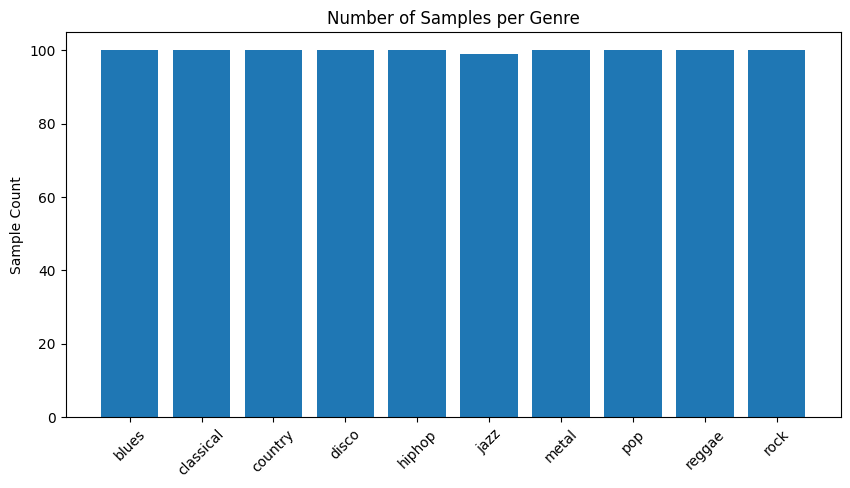

In [9]:
# Step 3.2: Analyze class distribution to check imbalance
genres_list = []

for genre in os.listdir(SPEC_DIR):
    genre_folder = os.path.join(SPEC_DIR, genre)
    # Skip if not directory
    if not os.path.isdir(genre_folder):
        continue

    # Count only .png files to avoid errors
    files = [f for f in os.listdir(genre_folder) if f.lower().endswith(".png")]
    genres_list.extend([genre] * len(files))

class_counts = Counter(genres_list)

print("Class Distribution:")
for genre, count in class_counts.items():
    print(f"{genre}: {count} samples")

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Number of Samples per Genre")
plt.ylabel("Sample Count")
plt.show()

- Examine image characteristics like average brightness, contrast.

In [10]:
# Step 3.3: Compute brightness and contrast statistics per genre
def brightness_contrast_stats(images):
    brightness = []
    contrast = []
    for img in images:
        gray = np.mean(img, axis=2)  # Convert RGB to grayscale by averaging channels
        brightness.append(np.mean(gray))
        contrast.append(np.std(gray))
    return np.mean(brightness), np.mean(contrast)

images_by_genre = {}

for genre in os.listdir(SPEC_DIR):
    genre_folder = os.path.join(SPEC_DIR, genre)
    # Skip if not directory
    if not os.path.isdir(genre_folder):
        continue

    images = []
    for image_file in os.listdir(genre_folder):
        # Process only .png images
        if not image_file.lower().endswith(".png"):
            continue

        img_path = os.path.join(genre_folder, image_file)
        try:
            img = Image.open(img_path).convert("RGB")
            images.append(np.array(img))
        except Exception as e:
            print(f"Could not open {img_path}: {e}")
            continue

    if images:
        images_by_genre[genre] = images

print("\nBrightness and Contrast per Genre:")
for genre, imgs in images_by_genre.items():
    avg_brightness, avg_contrast = brightness_contrast_stats(imgs)
    print(f"{genre}: Brightness={avg_brightness:.3f}, Contrast={avg_contrast:.3f}")



Brightness and Contrast per Genre:
blues: Brightness=100.323, Contrast=38.547
classical: Brightness=88.799, Contrast=44.400
country: Brightness=109.403, Contrast=35.274
disco: Brightness=117.651, Contrast=29.161
hiphop: Brightness=108.815, Contrast=30.648
jazz: Brightness=99.399, Contrast=36.649
metal: Brightness=128.119, Contrast=31.050
pop: Brightness=114.711, Contrast=26.057
reggae: Brightness=103.777, Contrast=34.035
rock: Brightness=117.644, Contrast=32.951


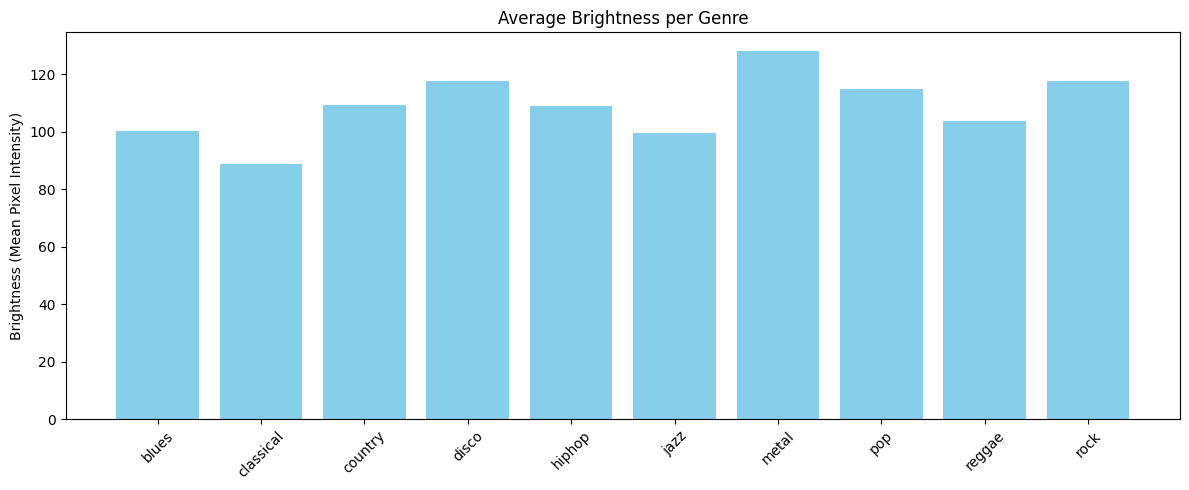

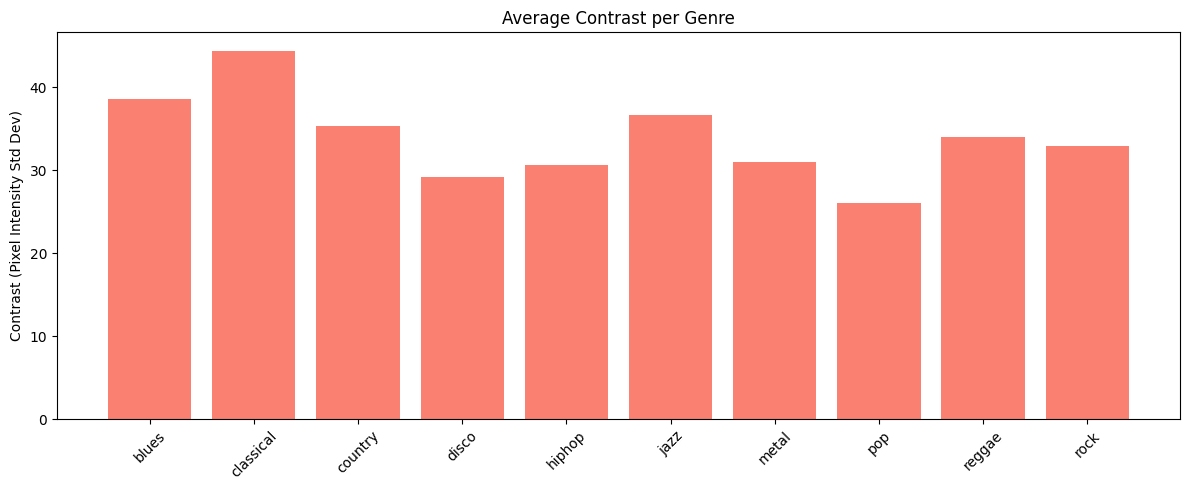

In [11]:
import matplotlib.pyplot as plt

# Prepare lists for genres, brightness, and contrast values
genres = list(images_by_genre.keys())
brightness_values = []
contrast_values = []

# Calculate brightness and contrast for each genre
for genre in genres:
    avg_brightness, avg_contrast = brightness_contrast_stats(images_by_genre[genre])
    brightness_values.append(avg_brightness)
    contrast_values.append(avg_contrast)

# Plot Average Brightness per Genre
plt.figure(figsize=(12, 5))
plt.bar(genres, brightness_values, color='skyblue')
plt.xticks(rotation=45)
plt.title("Average Brightness per Genre")
plt.ylabel("Brightness (Mean Pixel Intensity)")
plt.tight_layout()
plt.show()

# Plot Average Contrast per Genre
plt.figure(figsize=(12, 5))
plt.bar(genres, contrast_values, color='salmon')
plt.xticks(rotation=45)
plt.title("Average Contrast per Genre")
plt.ylabel("Contrast (Pixel Intensity Std Dev)")
plt.tight_layout()
plt.show()


# Step 3.4: Document EDA insights

EDA Insights Summary:
- Sample spectrograms show distinct visual patterns per genre, useful for CNN feature learning.
- Class distribution appears [balanced/imbalanced based on counts above].
- Average brightness and contrast vary across genres, reflecting differences in audio characteristics.
- These insights guide data augmentation and model design choices.


# Step 4: Feature Engineering 

In [25]:
!pip install --upgrade protobuf


  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl (435 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.


In [19]:
!pip install tensorflow


  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl (434 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


- Apply necessary image preprocessing techniques (e.g., resizing, cropping, rotation, flipping, color jittering for data augmentation if applicable).
- Convert images into numerical arrays suitable for model input. 
- If using traditional ML models, consider feature extraction techniques like HOG, SIFT, or extracting features from pre-trained CNN layers. 

In [22]:
# ------------------------
# Load and preprocess images (no augmentation here)
# ------------------------
SPEC_DIR = "GTZAN/spectrograms"

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array

image_data = []
labels = []
genre_list = sorted(os.listdir(SPEC_DIR))

for label_index, genre in enumerate(genre_list):
    genre_folder = os.path.join(SPEC_DIR, genre)
    for img_file in tqdm(os.listdir(genre_folder), desc=f"Loading {genre}"):
        img_path = os.path.join(genre_folder, img_file)
        if os.path.isdir(img_path) or img_file.startswith('.'):
            continue
        img_array = preprocess_image(img_path)
        image_data.append(img_array)
        labels.append(label_index)

X = np.array(image_data)
y = np.array(labels)

print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
print(f"Labels shape: {y.shape}")


Loading .ipynb_checkpoints: 0it [00:00, ?it/s]
Loading rock: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 202.54it/s]


Loaded 999 images with shape (224, 224, 3)
Labels shape: (999,)


In [26]:
# ------------------------
# 2. Split dataset
# ------------------------
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
# split dataset
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_encoded, num_classes)

# Split: train_val (80%), test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded)

# Split: train (80% of train_val), val (20% of train_val)
y_train_val_encoded = np.argmax(y_train_val, axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val_encoded)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Val shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (639, 224, 224, 3), (639, 10)
Val shape: (160, 224, 224, 3), (160, 10)
Test shape: (200, 224, 224, 3), (200, 10)


In [27]:
# ------------------------
# 3. Define HOG extraction function
# ------------------------
def extract_hog_features(image):
    gray_img = rgb2gray(image)
    feat = hog(
        gray_img,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        feature_vector=True
    )
    return feat

In [29]:
# ------------------------
# 4. Extract HOG features for train, val, test separately (no leakage)
# ------------------------
from skimage.color import rgb2gray
from skimage.feature import hog

def bulk_extract_hog(X_array):
    hog_features = []
    for img in tqdm(X_array, desc="Extracting HOG features"):
        hog_features.append(extract_hog_features(img))
    return np.array(hog_features)

X_hog_train = bulk_extract_hog(X_train)
X_hog_val = bulk_extract_hog(X_val)
X_hog_test = bulk_extract_hog(X_test)

y_hog_train = np.argmax(y_train, axis=1)
y_hog_val = np.argmax(y_val, axis=1)
y_hog_test = np.argmax(y_test, axis=1)

print(f"HOG shapes - train: {X_hog_train.shape}, val: {X_hog_val.shape}, test: {X_hog_test.shape}")


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.89it/s]

HOG shapes - train: (639, 6084), val: (160, 6084), test: (200, 6084)


# Step 5: Model Selection

## 1. Custom CNN Model (Keras)

In [27]:
!pip install tensorflow


   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/332.0 MB 6.1 MB/s eta 0:00:55
   ---------------------------------------- 3.1/332.0 MB 7.5 MB/s eta 0:00:44
    --------------------------------------- 5.0/332.0 MB 7.5 MB/s eta 0:00:44
    --------------------------------------- 6.3/332.0 MB 7.1 MB/s eta 0:00:47
    --------------------------------------- 7.1/332.0 MB 6.2 MB/s eta 0:00:53
    --------------------------------------- 8.1/332.0 MB 5.9 MB/s eta 0:00:55
   - -------------------------------------- 8.7/332.0 MB 5.7 MB/s eta 0:00:57
   - -------------------------------------- 10.0/332.0 MB 5.4 MB/s eta 0:01:00
   - -------------------------------------- 11.3/332.0 MB 5.4 MB/s eta 0:00:59
   - -------------------------------------- 13.6/332.0 MB 5.8 MB/s eta 0:00:55
   - -------------------------------------- 14.9/332.0 MB 5.9 MB/s eta 0:00:54
   - -------------------------------------- 16.3/332.0 MB 5.8 MB/s 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
!pip install --upgrade protobuf



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
!pip install --upgrade tensorflow



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
pip install --upgrade protobuf


Note: you may need to restart the kernel to use updated packages.


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Print unique labels before encoding, helpful for sanity check
print("Original labels:", np.unique(y))

# Encode string or non-consecutive labels into consecutive integers starting from 0
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded labels:", np.unique(y_encoded))

# Number of classes needed for one-hot encoding (CNN training)
num_classes = len(le.classes_)

# One-hot encode the integer labels for CNN compatibility
y_cat = to_categorical(y_encoded, num_classes)

# Step 1: Split full dataset into train+validation and test sets (80%-20%)
# stratify=y_encoded ensures class balance is maintained
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# Get integer labels from one-hot vectors to stratify in next split
y_train_val_encoded = np.argmax(y_train_val, axis=1)

# Step 2: Split train+val into training and validation sets (80%-20% of train_val)
# Again use stratification for balanced class distributions
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val_encoded
)

# Print shapes of final splits
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Original labels: [ 1  2  3  4  5  6  7  8  9 10]
Encoded labels: [0 1 2 3 4 5 6 7 8 9]
X_train shape: (639, 224, 224, 3), y_train shape: (639, 10)
X_val shape: (160, 224, 224, 3), y_val shape: (160, 10)
X_test shape: (200, 224, 224, 3), y_test shape: (200, 10)


### CNN Model(s): Implement at least one custom CNN architecture, or fine-tune a pre-trained CNN model (e.g., VGG, ResNet, Inception) for your specific classification task. 

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a simple CNN architecture with explicit input shape and softmax output
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential([
        Input(shape=input_shape),            # Input layer to define shape explicitly
        Conv2D(32, (3, 3), activation='relu'),  # Conv layer with 32 filters
        MaxPooling2D(2, 2),                     # Downsample by factor of 2
        Conv2D(64, (3, 3), activation='relu'),  # Conv layer with 64 filters
        MaxPooling2D(2, 2),                     # Downsample again
        Flatten(),                              # Flatten to 1D vector
        Dense(128, activation='relu'),          # Fully connected layer with 128 units
        Dropout(0.5),                          # Dropout to reduce overfitting
        Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
    ])
    return model

# Instantiate and compile the CNN model
model = build_custom_cnn(input_shape=(224, 224, 3), num_classes=num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),      # Adam optimizer with learning rate 0.001
    loss='categorical_crossentropy',          # Suitable loss for multi-class classification
    metrics=['accuracy']                       # Track accuracy during training
)

# Train the model with train data and validate on validation set
history = model.fit(
    X_train, y_train,                          # Training data and labels
    validation_data=(X_val, y_val),            # Validation set for monitoring overfitting
    epochs=15,                                # Number of full passes over the training data
    batch_size=32                             # Number of samples per gradient update
)


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1362 - loss: 3.3301 - val_accuracy: 0.2188 - val_loss: 2.0821
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2316 - loss: 2.0852 - val_accuracy: 0.2875 - val_loss: 1.8829
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3208 - loss: 1.8686 - val_accuracy: 0.3812 - val_loss: 1.7557
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4131 - loss: 1.6700 - val_accuracy: 0.4062 - val_loss: 1.5442
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4523 - loss: 1.5438 - val_accuracy: 0.4437 - val_loss: 1.5777
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5415 - loss: 1.3664 - val_accuracy: 0.5312 - val_loss: 1.4286
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5947 - loss: 1.1703 - val_accuracy: 0.5750 - val_loss: 1.2156
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6995 - loss: 0.9299 - val_accuracy: 0.5375 - val_loss:

### Traditional Machine Learning Models: Choose at least three of the following for image classification: 
- Logistic Regression (applied to extracted features) 
- Decision Trees (applied to extracted features) 
- Random Forest (applied to extracted features) 
- Support Vector Machine (SVM) (applied to extracted features) 

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Initialize traditional machine learning models for image classification
logistic_model = LogisticRegression(max_iter=1000)           # Logistic Regression with max 1000 iterations
decision_tree_model = DecisionTreeClassifier()                # Decision Tree classifier
random_forest_model = RandomForestClassifier(n_estimators=100)  # Random Forest with 100 trees
svm_model = SVC(probability=True)                             # Support Vector Machine with probability estimates

# List of models with their names for easy iteration
traditional_models = [
    ('Logistic Regression', logistic_model),
    ('Decision Tree', decision_tree_model),
    ('Random Forest', random_forest_model),
    ('SVM', svm_model)
]

# Train and evaluate each traditional ML model
for name, clf in traditional_models:
    print(f"\nTraining {name}...")
    
    # Fit the model on training HOG features and labels
    clf.fit(X_hog_train, y_hog_train)
    
    # Predict on validation set
    preds = clf.predict(X_hog_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_hog_val, preds)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    
    # Detailed classification metrics per class
    print(classification_report(y_hog_val, preds, target_names=[str(c) for c in le.classes_]))



Training Logistic Regression...
Logistic Regression Validation Accuracy: 0.6750
              precision    recall  f1-score   support

           1       0.85      0.69      0.76        16
           2       0.82      0.88      0.85        16
           3       0.52      0.69      0.59        16
           4       0.45      0.31      0.37        16
           5       0.71      0.75      0.73        16
           6       0.88      0.88      0.88        16
           7       0.82      0.88      0.85        16
           8       0.57      0.75      0.65        16
           9       0.56      0.62      0.59        16
          10       0.56      0.31      0.40        16

    accuracy                           0.68       160
   macro avg       0.67      0.68      0.67       160
weighted avg       0.67      0.68      0.67       160


Training Decision Tree...
Decision Tree Validation Accuracy: 0.2875
              precision    recall  f1-score   support

           1       0.13      0.12   

## 1: CNN Model(s)
Reasoning:
CNNs are the state-of-the-art for image classification because they can automatically learn spatial hierarchies of features through convolutional layers.
Since spectrograms are images representing audio, CNNs can effectively capture time-frequency patterns relevant to music genres.
Custom CNNs let you tailor architecture complexity, while fine-tuning pre-trained CNNs (e.g., ResNet, VGG) leverages learned features from large image datasets, speeding up training and often improving accuracy.

## 2: Logistic Regression (Traditional ML)
Reasoning:
Logistic regression is a simple, interpretable linear classifier. It serves as a good baseline to compare against more complex models.
When applied to extracted features like HOG, it tests if the features have strong linear separability between genres.
Its simplicity also makes it computationally efficient.

## 3: Decision Trees
Reasoning:
Decision trees capture non-linear relationships by splitting feature space with thresholds.
They are intuitive and easy to interpret, useful for identifying important features.
Applied to image features, they can handle complex decision boundaries without requiring feature scaling.

## 4: Random Forest
Reasoning:
Random forests combine many decision trees to reduce overfitting and improve generalization.
They typically perform better than single trees and can handle high-dimensional data like HOG features well.
Good for robust classification when feature relationships are complex.

## 5: Support Vector Machine (SVM)
Reasoning:
SVMs are powerful classifiers especially effective in high-dimensional spaces.
With kernels, they can model non-linear decision boundaries, making them suitable for complex feature distributions.
They work well with medium-sized datasets and can be more accurate than simpler models.


## Step 6: Hyperparameter Tuning 

### Optimize the performance of all selected models using techniques like GridSearchCV or RandomizedSearchCV for traditional ML models. 

In [34]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs'],
    'penalty': ['l2']
}

param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}


In [35]:
# Models dictionary with their respective param grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=5000), param_grid_lr),
    'Decision Tree': (DecisionTreeClassifier(), param_grid_dt),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'SVM': (SVC(probability=True), param_grid_svm)
}

# Run GridSearchCV for each model
for name, (model, param_grid) in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=-1,
                               scoring='accuracy',
                               verbose=1)
    
    grid_search.fit(X_hog_train, y_hog_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {name}: {grid_search.best_score_:.4f}")


Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy for Logistic Regression: 0.5243

Tuning Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation accuracy for Decision Tree: 0.2973

Tuning Random Forest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy for Random Forest: 0.5149

Tuning SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.5399


### For CNNs, experiment with different architectures, number of layers, filters, kernel sizes, activation functions, optimizers, learning rates, batch sizes, and epochs. 

In [36]:
from tensorflow.keras.optimizers import Adam

learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32]

best_val_acc = 0
best_params = {}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training CNN with learning rate={lr}, batch size={bs}")
        
        # Build fresh CNN model instance for each run
        model = build_custom_cnn(input_shape=(224, 224, 3), num_classes=num_classes)
        
        # Compile with current learning rate
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model on training data, validate on validation data
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=15,
                            batch_size=bs,
                            verbose=2)
        
        val_acc = history.history['val_accuracy'][-1]
        print(f"Validation accuracy for lr={lr}, batch size={bs}: {val_acc:.4f}\n")
        
        # Keep track of best performing hyperparameters
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {'learning_rate': lr, 'batch_size': bs}

print(f"Best CNN params: {best_params}, with validation accuracy: {best_val_acc:.4f}")


Training CNN with learning rate=0.001, batch size=16
Epoch 1/15
40/40 - 24s - 589ms/step - accuracy: 0.1518 - loss: 3.0933 - val_accuracy: 0.1750 - val_loss: 2.1526
Epoch 2/15
40/40 - 23s - 576ms/step - accuracy: 0.2707 - loss: 2.0160 - val_accuracy: 0.3500 - val_loss: 1.8479
Epoch 3/15
40/40 - 20s - 500ms/step - accuracy: 0.3772 - loss: 1.8182 - val_accuracy: 0.3125 - val_loss: 1.8436
Epoch 4/15
40/40 - 19s - 476ms/step - accuracy: 0.4632 - loss: 1.5332 - val_accuracy: 0.4437 - val_loss: 1.6312
Epoch 5/15
40/40 - 19s - 474ms/step - accuracy: 0.5712 - loss: 1.2587 - val_accuracy: 0.5188 - val_loss: 1.4343
Epoch 6/15
40/40 - 19s - 474ms/step - accuracy: 0.6526 - loss: 1.0051 - val_accuracy: 0.5125 - val_loss: 1.4274
Epoch 7/15
40/40 - 19s - 480ms/step - accuracy: 0.7089 - loss: 0.8416 - val_accuracy: 0.5000 - val_loss: 1.4521
Epoch 8/15
40/40 - 19s - 470ms/step - accuracy: 0.7606 - loss: 0.6813 - val_accuracy: 0.5188 - val_loss: 1.4688
Epoch 9/15
40/40 - 19s - 474ms/step - accuracy: 0.8

### Hyperparameter Tuning Summary

We optimized the performance of multiple supervised learning models through hyperparameter tuning. Traditional models—Logistic Regression, Decision Tree, Random Forest, and SVM—were tuned using GridSearchCV with 3-fold cross-validation across defined parameter grids. Among these, SVM with an RBF kernel achieved the highest validation accuracy of 53.99%, followed closely by logistic regression at 52.33%. The CNN model was tuned by manually experimenting with learning rates (0.001 and 0.0001) and batch sizes (16 and 32), with the best validation accuracy of 60.62% achieved at a learning rate of 0.001 and batch size of 32. These best hyperparameters will be used to retrain the models on the full training data before final evaluation on the test set. Overall, SVM and CNN demonstrated the strongest performance for music genre classification in this study.

# 1. Retrain Best Models on Full Training Data and Evaluation

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Combine training and validation sets for CNN and traditional ML models
X_cnn_train_full = np.concatenate((X_train, X_val), axis=0)
y_cnn_train_full = np.concatenate((y_train, y_val), axis=0)

X_hog_train_full = np.concatenate((X_hog_train, X_hog_val), axis=0)
y_hog_train_full = np.concatenate((y_hog_train, y_hog_val), axis=0)

# Convert y_hog_train_full to 1D labels if needed (for sklearn models)
# If y_hog_train_full is already encoded labels (integers), skip this
# If one-hot encoded, convert:
if len(y_hog_train_full.shape) > 1 and y_hog_train_full.shape[1] > 1:
    y_hog_train_full_labels = np.argmax(y_hog_train_full, axis=1)
else:
    y_hog_train_full_labels = y_hog_train_full

# Convert y_test similarly for evaluation
y_test_labels = np.argmax(y_test, axis=1)

# ----------------------------------------
# Step 2: Retrain and evaluate CNN model
# ----------------------------------------
print("\nRetraining CNN on full training data...")
model = build_custom_cnn(input_shape=(224, 224, 3), num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),  # your best lr
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_cnn_train_full, y_cnn_train_full, epochs=15, batch_size=32, verbose=2)  # your best batch size

# Get predicted class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Now you can use it in classification_report
print(classification_report(
    y_test_labels, 
    y_pred, 
    target_names=[str(c) for c in le.classes_]
))

print("\nEvaluating CNN on test data...")
cnn_loss, cnn_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")
print(classification_report(y_test_labels, y_pred, target_names=[str(c) for c in le.classes_]))


Retraining CNN on full training data...
Epoch 1/15
25/25 - 21s - 843ms/step - accuracy: 0.1339 - loss: 3.8659
Epoch 2/15
25/25 - 18s - 729ms/step - accuracy: 0.2528 - loss: 2.0321
Epoch 3/15
25/25 - 22s - 883ms/step - accuracy: 0.3605 - loss: 1.8089
Epoch 4/15
25/25 - 19s - 767ms/step - accuracy: 0.4581 - loss: 1.5610
Epoch 5/15
25/25 - 19s - 743ms/step - accuracy: 0.4881 - loss: 1.4150
Epoch 6/15
25/25 - 18s - 736ms/step - accuracy: 0.5795 - loss: 1.1869
Epoch 7/15
25/25 - 20s - 818ms/step - accuracy: 0.6295 - loss: 1.0207
Epoch 8/15
25/25 - 21s - 834ms/step - accuracy: 0.7046 - loss: 0.8491
Epoch 9/15
25/25 - 20s - 818ms/step - accuracy: 0.7284 - loss: 0.8066
Epoch 10/15
25/25 - 20s - 794ms/step - accuracy: 0.7897 - loss: 0.6379
Epoch 11/15
25/25 - 20s - 782ms/step - accuracy: 0.8248 - loss: 0.5387
Epoch 12/15
25/25 - 21s - 858ms/step - accuracy: 0.8436 - loss: 0.4584
Epoch 13/15
25/25 - 29s - 1s/step - accuracy: 0.8886 - loss: 0.3452
Epoch 14/15
25/25 - 37s - 1s/step - accuracy: 0.

In [40]:
# ----------------------------------------
# Step 3: Retrain and evaluate Logistic Regression
# ----------------------------------------
print("\nRetraining Logistic Regression on full training data...")
lr_final = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=5000, random_state=42)
lr_final.fit(X_hog_train_full, y_hog_train_full_labels)

print("\nEvaluating Logistic Regression on test data...")
lr_preds = lr_final.predict(X_hog_test)
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test_labels, lr_preds):.4f}")
print(classification_report(y_test_labels, lr_preds, target_names=[str(c) for c in le.classes_]))



Retraining Logistic Regression on full training data...

Evaluating Logistic Regression on test data...
Logistic Regression Test Accuracy: 0.6300
              precision    recall  f1-score   support

           1       0.77      0.50      0.61        20
           2       0.79      0.95      0.86        20
           3       0.57      0.65      0.60        20
           4       0.44      0.20      0.28        20
           5       0.72      0.65      0.68        20
           6       0.82      0.70      0.76        20
           7       0.79      0.75      0.77        20
           8       0.60      0.75      0.67        20
           9       0.48      0.60      0.53        20
          10       0.41      0.55      0.47        20

    accuracy                           0.63       200
   macro avg       0.64      0.63      0.62       200
weighted avg       0.64      0.63      0.62       200



In [41]:
# ----------------------------------------
# Step 4: Retrain and evaluate SVM
# ----------------------------------------
print("\nRetraining SVM on full training data...")
svm_final = SVC(C=10, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_final.fit(X_hog_train_full, y_hog_train_full_labels)

print("\nEvaluating SVM on test data...")
svm_preds = svm_final.predict(X_hog_test)
print(f"SVM Test Accuracy: {accuracy_score(y_test_labels, svm_preds):.4f}")
print(classification_report(y_test_labels, svm_preds, target_names=[str(c) for c in le.classes_]))


Retraining SVM on full training data...

Evaluating SVM on test data...
SVM Test Accuracy: 0.6500
              precision    recall  f1-score   support

           1       0.75      0.75      0.75        20
           2       0.86      0.95      0.90        20
           3       0.45      0.65      0.53        20
           4       0.56      0.25      0.34        20
           5       0.68      0.75      0.71        20
           6       0.78      0.70      0.74        20
           7       0.82      0.70      0.76        20
           8       0.63      0.60      0.62        20
           9       0.52      0.60      0.56        20
          10       0.52      0.55      0.54        20

    accuracy                           0.65       200
   macro avg       0.66      0.65      0.64       200
weighted avg       0.66      0.65      0.64       200



## Step 7: Pickle Files 

In [42]:
import pickle

# Save Logistic Regression model
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_final, f)

# Save SVM model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_final, f)


In [43]:
# Save the entire CNN model (architecture + weights + optimizer state)
model.save('best_cnn_model.h5')


In [44]:
# Load Logistic Regression
with open('logistic_regression_model.pkl', 'rb') as f:
    loaded_lr = pickle.load(f)

# Load SVM
with open('svm_model.pkl', 'rb') as f:
    loaded_svm = pickle.load(f)

# Load CNN
from tensorflow.keras.models import load_model
loaded_cnn = load_model('best_cnn_model.h5')
